In [24]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [25]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [26]:
X_train.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39


In [27]:
X_train.dtypes

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int32
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

In [28]:
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [34]:
gbm = lgb.LGBMClassifier(objective='mape', num_leaves=31, learning_rate=0.05,
                        n_estimators=200)
gbm.fit(
    X_train[: int(X_train.shape[0] * 0.99)], y_train[: int(y_train.shape[0] * 0.99)],
    eval_set=[(X_train[int(X_train.shape[0] * 0.01):], y_train[int(y_train.shape[0] * 0.01):])],
    eval_metric='mape',
    early_stopping_rounds=100,
    verbose=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.14453
[200]	valid_0's mape: 0.140256
Did not meet early stopping. Best iteration is:
[200]	valid_0's mape: 0.140256


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective='mape',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

# 两种训练方式不同
# 打印结果的时候也不同

Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.298132
[200]	valid_0's binary_logloss: 0.284485
[300]	valid_0's binary_logloss: 0.28034
[400]	valid_0's binary_logloss: 0.278335
[500]	valid_0's binary_logloss: 0.27763
[600]	valid_0's binary_logloss: 0.277276
[700]	valid_0's binary_logloss: 0.277306
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


# Explain predictions

#### Here we use the Tree SHAP implementation integrated into Light GBM to explain the entire dataset (32561 samples).

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [12]:
len(shap_values)

2

## Visualize a single prediction

#### Note that we use the "display values" data frame so we get nice strings instead of category codes.

In [19]:
X_display.iloc[0,:]

Age                           39
Workclass              State-gov
Education-Num                 13
Marital Status     Never-married
Occupation          Adm-clerical
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain                2174
Capital Loss                   0
Hours per week                40
Country            United-States
Name: 0, dtype: object

In [7]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

In [20]:
shap.force_plot(explainer.expected_value[1], shap_values[1][3,:], X_display.iloc[3,:])

In [9]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

## SHAP Summary Plot

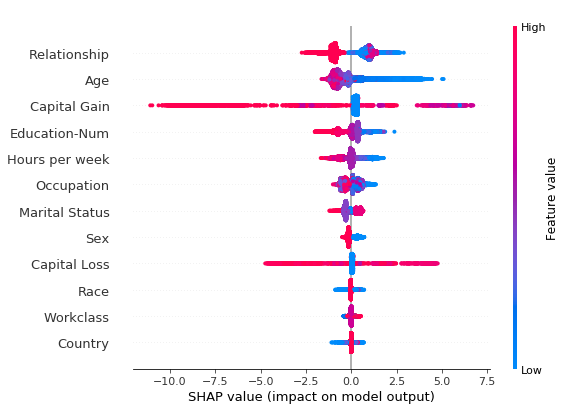

In [14]:
shap.summary_plot(shap_values[0], X)

## SHAP Dependence Plots

#### SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

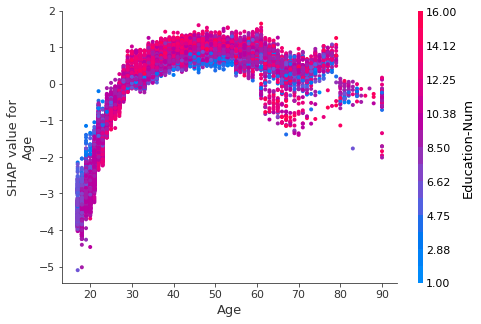

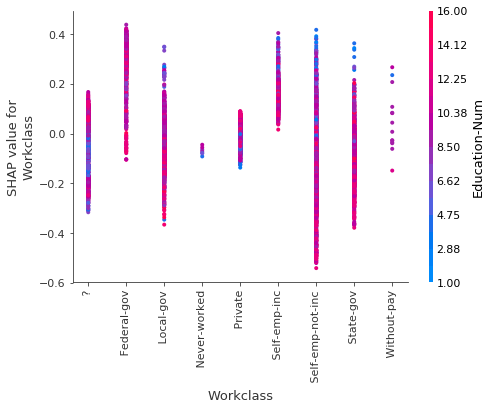

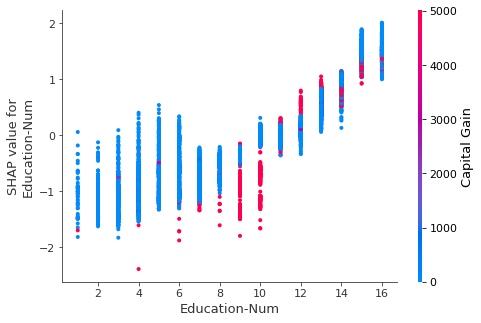

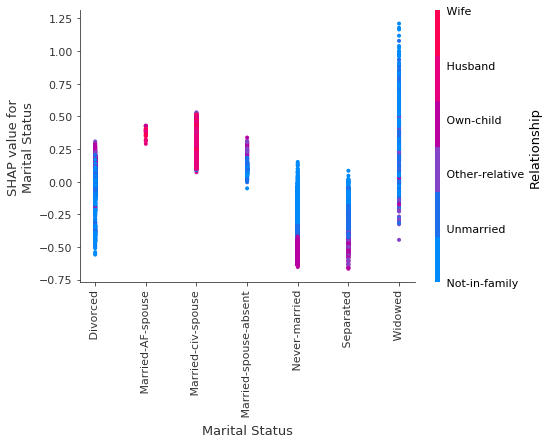

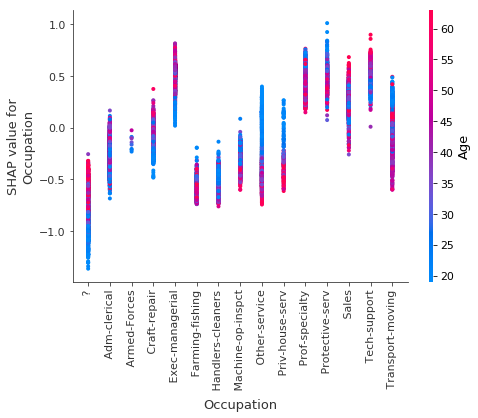

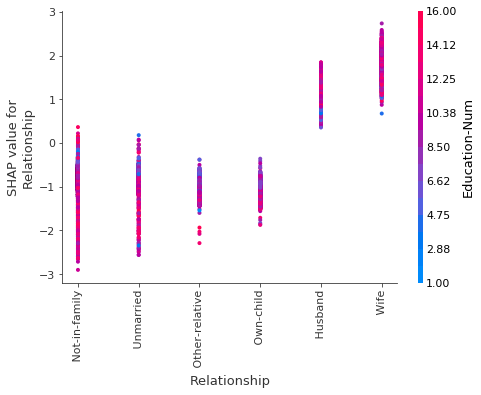

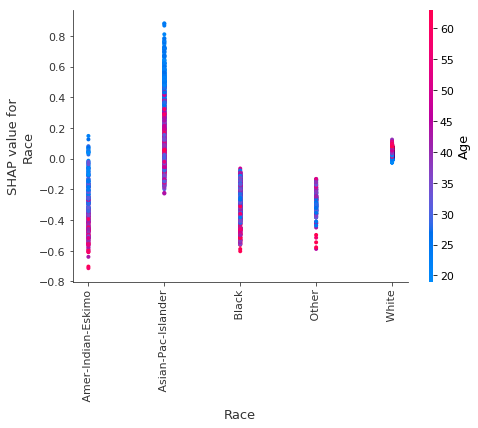

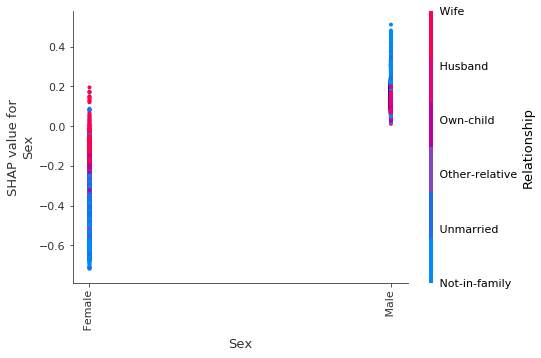

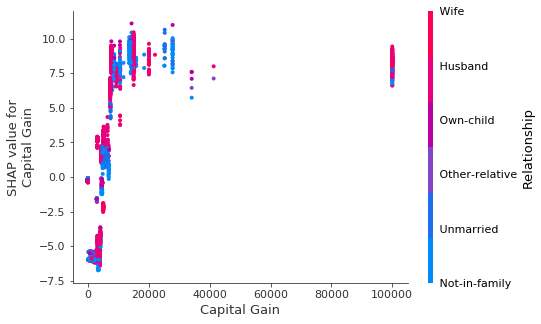

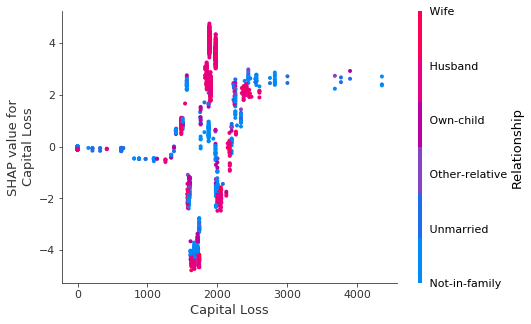

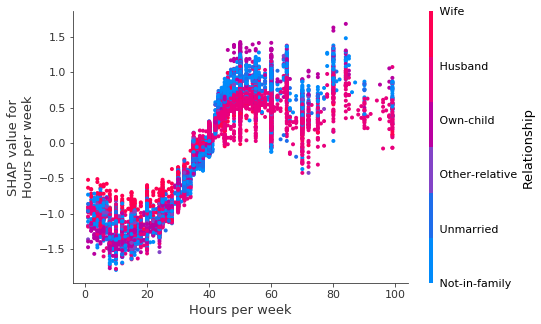

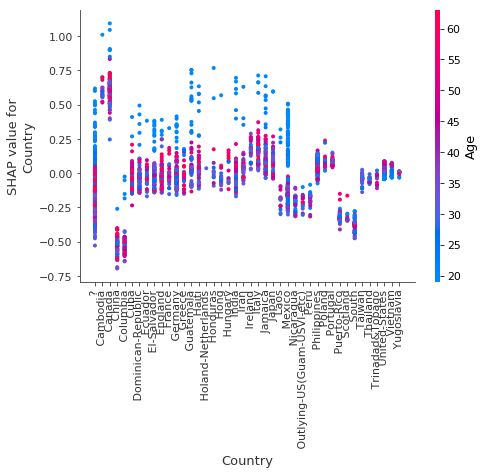

In [11]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)